In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import faiss

from core.clip import CLIP
from core.faiss_index import FaissIndex
from core.queries import QueryType, select_queries
from core.retrieve_image import download_image
import configs
from utils import laion_utils as laionu
from utils import logging_utils as logu

/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

In [3]:
# LAION
laion_path = 'laion400m'
laion_part = 0

# Version
index_ver = ''

# Path
faiss_index_path = os.path.join('laion400m', 'processed', 'faiss_index', f'knn{index_ver}.index')
indices_path = os.path.join('laion400m', 'processed', 'clip_text_indices', f'all_indices{index_ver}.npy')

logu.verbose = True

# Load index and indices

In [4]:
faiss_index = FaissIndex.load(faiss_index_path, indices_path)

loading indices ...
	found 413871335 rows in all_indices.
done!

loading faiss index ...
	found 413871335 rows in faiss index.
done!



# Load LAION part

In [5]:
df = laionu.load_data_part(laion_path, laion_part, self_destruct=True)

df.tail(3)

loading laion part 0 ...
	downloading laion part 0 ...
	downloaded!
	removing laion part 0 from the disk ...
	removed!
done!



,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
12933521,3.405165e+12,https://cdn.shopify.com/s/files/1/0142/2173/80...,#1 Mom Heart Pendant,300.0,300.0,?,UNLIKELY,0.311529
12933522,1.394591e+12,https://3.bp.blogspot.com/-6M42JtD_Ht8/Ut__TVV...,Wedding entertainment North East corporate eve...,1131.0,1600.0,?,UNSURE,0.351486
12933523,2.729011e+12,https://cdn.shopify.com/s/files/1/0625/2813/pr...,Nautilus Womens Grey/Aqua Leather Steel Toe WP...,480.0,480.0,?,UNLIKELY,0.360971


# Init.

In [6]:
clip = CLIP()

# Query

In [24]:
wnid = 'n02123394'

q_func = select_queries([QueryType.NAME_DEF])[0]

query = q_func(wnid)

n_result = 500

In [25]:
# Get CLIP embedding
embed = clip.text_embeds([query])
embed_norm = normalize(embed, norm='l2', axis=1)

# Search the index
indices, cos_sims = faiss_index.search(embed_norm, n_result)

indices = indices[0]
cos_sims = cos_sims[0]

Attempting to cast a BatchEncoding to type None. This is not supported.


# Postprocess

In [26]:
# Restrict the results to this LAION part
indices = np.intersect1d(indices, df.index)

# Extract the rows
df_q = df.loc[indices]

# Remove NSFW
df_q = df_q.loc[df_q['NSFW'] == configs.LAIONConfig.SAFE_TAG]

df_q.head(10)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
630116,2.706278e+12,https://pulpbits.net/wp-content/uploads/2014/0...,Chinchilla Persian Cat in,330.0,220.0,?,UNLIKELY,0.327168
841155,2.594345e+12,https://img.claz.org/t/400x320/bdgz53-ChATCkYJ...,Cute Persian Kittens Currently Available,347.0,320.0,?,UNLIKELY,0.310095
1747377,1.008443e+12,https://olxbhimages-a.akamaihd.net/52a5c3a75d8...,Beautiful persian cat for sale,261.0,195.0,?,UNLIKELY,0.311224
1995021,6.885000e+10,http://www.pictures-of-cats.org/images/persian...,Persian cat photo,502.0,516.0,?,UNLIKELY,0.308213
3193677,2.864788e+12,https://cdn1-www.dogtime.com/assets/uploads/ga...,Pomeranian Dog Breed Information Pictures Char...,680.0,452.0,?,UNLIKELY,0.338982
3967859,2.470869e+12,https://www.siberiancatworld.com/wp-content/up...,Are Siberian cats friendly,447.0,293.0,?,UNLIKELY,0.382884
4813415,1.294510e+11,https://t2.ftcdn.net/jpg/00/32/03/37/160_F_320...,Female crossbreed of siberian and persian cat.,160.0,110.0,?,UNLIKELY,0.313618
4839347,3.286148e+12,https://shorcuts.us/wp-content/uploads/thon/to...,Toy Cats for Sale toy Persian Kittens for Sale...,300.0,170.0,?,UNLIKELY,0.341227
4967014,4.122873e+12,https://pictures-of-cats.org/wp-content/upload...,Traditional Persian Cat,500.0,375.0,?,UNLIKELY,0.306083
6194110,1.403723e+12,https://pulpbits.net/wp-content/uploads/2014/0...,Short Haired Persian kittens in Dog,330.0,220.0,?,UNLIKELY,0.301741


# Download the images

In [27]:
images = []
for idx, row in tqdm(df_q.iterrows(), total=len(df_q)):
    try:
        image = download_image(row['URL'])
    except Exception as e:
        continue
    images.append(image)
    

print(f'\nSuccessfully downloaded {len(images)} out of {len(df_q)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.06it/s]


Successfully downloaded 13 out of 17


# Display

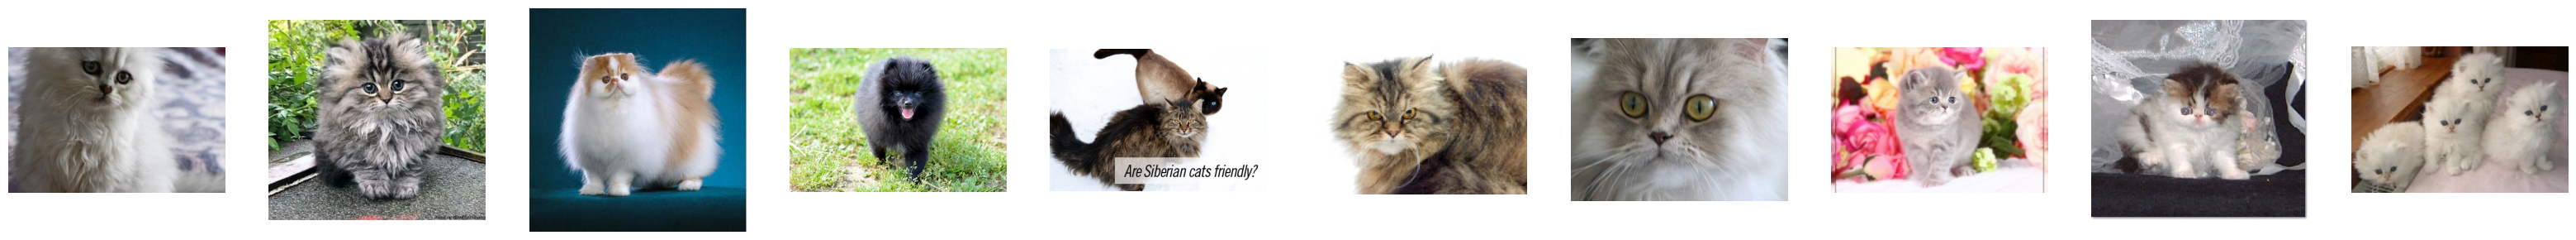

In [28]:
%matplotlib inline

k_show = 10
        
fig, axs = plt.subplots(1, k_show, figsize=(k_show*4, 4))

for i_ax, image in enumerate(images[:k_show]):
    axs[i_ax].imshow(image)
    axs[i_ax].axis('off')
